# Nonlinear Regression, Spline, Lasso, Model Selection, Double Descent


## 1. Piecewise Nonlinear Regression  
1. Consider the data generated below from the trigonometric regression function $y=\sin(2\pi x)+\varepsilon$. Use three types of bases to perform nonlinear regression: a) piecewise constant, b) piecewise linear, c) continuous piecewise linear (1st degree spline) with internal breakpoints at 1/3 and 2/3 (i.e., the "pieces" are [0,1/3), [1/3,2/3), and [2/3,1]). Similar models are fit in Fig. 5.1 on p. 142 of ESL, which is replicated below.
Come up with the appropriate bases function for each case and create the corresponding features to use in regression. Then fit the models and plot the resulting fits, on top of the simulated data and the true regression function.

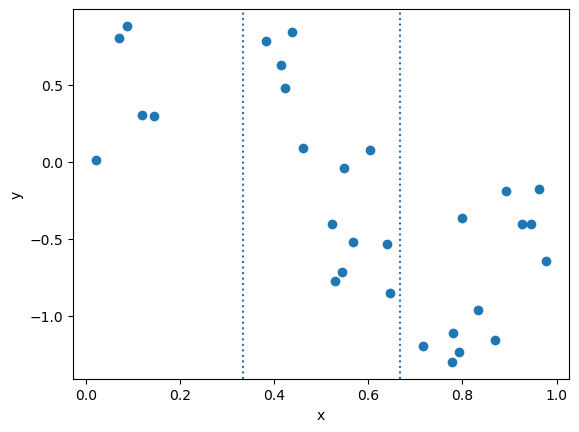

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data from y = f(x) + ε = sin(2*π*x) + ε
np.random.seed(0); N = 30
x = np.random.rand(N)
y = np.sin( 2*np.pi*x ) + np.random.normal(0, .3, N) 

# Plot the original data and the spline
plt.plot(x, y, 'o', label='Data')
plt.axvline(1/3, linestyle = ':' )
plt.axvline(2/3, linestyle = ':' )
plt.xlabel('x'); plt.ylabel('y');


![](piecewise_const_linear_regression.png)

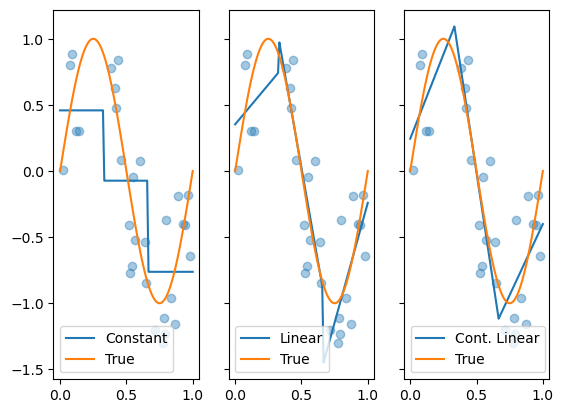

In [2]:
### Use Bases & LinearRegression : a) piecewise constant, b) piecewise linear, c) continuous piecewise linear 

X_const =  np.column_stack( ( (x<1/3)*1, ((x>=1/3)&(x<=2/3)) *1, (x>2/3)*1 ) ) 
X_lin =  np.column_stack( ( X_const, (x<1/3)*x, ((x>=1/3)&(x<=2/3))*(x-1/3), (x>2/3)*(x-2/3) ) ) 
         # 3 from X_const + 3 = 6 = 2 (degree+1) * 3 (internal knots 2 + 1 ) - 0 (no constraints)
X_cont_lin =  np.column_stack( ( np.ones(x.shape), x, (x-1/3)*(x>=1/3), (x-2/3)*(x>2/3) ) ) 

from sklearn.linear_model import LinearRegression
# LinearRegression will defaultly add ones to design matrix
lm_const = LinearRegression(fit_intercept=False).fit(X_const, y)
lm_lin = LinearRegression(fit_intercept=False).fit(X_lin, y)
lm_cont_lin = LinearRegression(fit_intercept=False).fit(X_cont_lin, y)

x_plot = np.linspace(0,1,100).reshape(-1,1)
X_const_plot =  np.column_stack( ( (x_plot<1/3)*1, ((x_plot>=1/3)&(x_plot<=2/3)) *1, (x_plot>2/3)*1 ) ) 
X_lin_plot =  np.column_stack( ( X_const_plot, (x_plot<1/3)*x_plot, ((x_plot>=1/3)&(x_plot<=2/3)) *(x_plot-1/3), (x_plot>2/3)*(x_plot-2/3) ) ) 
X_cont_lin_plot =  np.column_stack( ( np.ones(x_plot.shape), x_plot, (x_plot-1/3)*(x_plot>=1/3), (x_plot-2/3)*(x_plot>2/3) ) ) 


fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].scatter( x, y, alpha = .4)
axs[0].plot( x_plot, lm_const.predict(X_const_plot), label = "Constant")
axs[0].plot( x_plot, np.sin( 2*np.pi*x_plot ), label = "True")
axs[0].legend();
axs[1].scatter( x, y, alpha = .4)
axs[1].plot( x_plot, lm_lin.predict(X_lin_plot), label = "Linear")
axs[1].plot( x_plot, np.sin( 2*np.pi*x_plot ), label = "True")
axs[1].legend();
axs[2].scatter( x, y, alpha = .4)
axs[2].plot( x_plot, lm_cont_lin.predict(X_cont_lin_plot) , label = "Cont. Linear")
axs[2].plot( x_plot, np.sin( 2*np.pi*x_plot ), label = "True")
axs[2].legend();

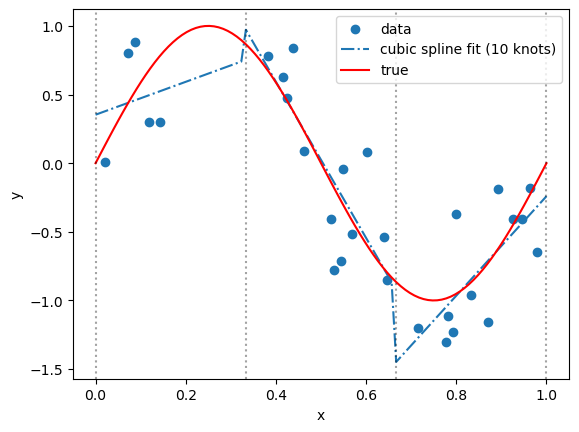

In [3]:
# Scipy - make_lsq_spline: e.g. piecewise linear 

k = 1 # degree of polynomial 

knots =  np.array([0,0,1/3,1/3,2/3,2/3,1,1]) 
    ## start and end need repeat k(degree)+1      
    ## 1/3 and 2/3 repeat i=2 times since need k-i order of continuity (-1 means not continuous)

from scipy.interpolate import make_lsq_spline
y = y[np.argsort(x)]; x.sort()  # make_lsq_spline requires sorted data
piecewise_linear_spl = make_lsq_spline(x, y, knots, k)

plt.scatter(x, y, label='data')
x_span = np.linspace(0, 1, 100)  # create x-values for plotting function 
y_span_fun = np.sin( 2*np.pi*x_span )        # calculate function evaluations 
plt.plot(x_span, piecewise_linear_spl(x_span), '-.', label='cubic spline fit (10 knots)')
plt.plot( x_span, y_span_fun, 'r', label='true'  )
for i in knots:
    ## draw verticle dash line at knots
    plt.axvline(x = i, color = 'k', linestyle = ":" , alpha = .2) 
plt.xlabel('x'); plt.ylabel('y'); plt.legend()
plt.show()

## 2. Variable selection & Lasso

The following code loads the *prostate cancer data* described in section 3.2.1 (p. 49) of ESL. (The data are available at this [Github repo](https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/data/Prostate%20Cancer.txt)). 

In [4]:
import pandas as pd
url = "https://raw.githubusercontent.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/refs/heads/master/data/Prostate%20Cancer.txt" 
df = pd.read_csv(url, header=0); 
y = df["lpsa"]; 
X = df[ ["lcavol", "lweight", "age", "lbph", "svi", "lcp", "gleason", "pgg45" ] ]
X.head(3)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20


Perform the following analyses using available `sklearn` functions:

### 2.(a) Forward Feature Selection
*Forward Feature Selection* using `sklearn.feature_selection.SequentialFeatureSelector()`. With default parameters, the function sequentially adds features to the model, choosing the one that optimizes 5-fold CV, and stops at a predetermined number of features. Run the function to find the selected model with 4 features, and print the selected feature's names.

In [5]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

fwd = SequentialFeatureSelector( LinearRegression(), n_features_to_select = 4 )
fwd.fit(X, y)
print("Selected Features Name:",fwd.get_feature_names_out())

fwdreg = LinearRegression().fit( fwd.transform(X), y) # fwd.transform(X): Reduce X to the selected features.
print("Estimated Intercept:",fwdreg.intercept_)
print("Estimated Coefficient:",fwdreg.coef_)

Selected Features Name: ['lcavol' 'lweight' 'age' 'gleason']
Estimated Intercept: -1.3055986060391116
Estimated Coefficient: [ 0.61776382  0.76847022 -0.0155574   0.171024  ]


### 2.(b) Lasso regression: Standardize features, Lasso - feature selection
*Lasso regression* using `sklearn.linear_model.Lasso()`. You first need to standardize all the features with `sklearn.preprocessing.StandardScaler()`, and then apply `Lasso()` with smoothness penalty (`alpha` parameter in function) of $\lambda = 0.1$. 
Print the parameters of the fitted model, and identify which features are included in the final model. 


In [6]:
from sklearn.preprocessing import StandardScaler 
std_scaler = StandardScaler().fit(X)  # fit mean & variance
Xstd = std_scaler.transform(X)  # transform data 
# Xstd = StandardScaler().fit_transform(X)  # or fit & transform at once

from sklearn.linear_model import Lasso
lasso = Lasso( alpha = 0.1 ).fit(Xstd, y) # fit Lasso regression
print(lasso.coef_) # print Lasso coefficients; only 5 are non-zero

print( X.keys()[ (lasso.coef_ != 0) ] ) # print names of non-zero coefficients

[ 0.56779248  0.19482671 -0.          0.02071651  0.20566518  0.
  0.          0.02208466]
Index(['lcavol', 'lweight', 'lbph', 'svi', 'pgg45'], dtype='object')


### 2.(c) Lasso Coefficients <= Linear Regression
Fit a regular Linear Regression to all standardized features and look at the resulting coefficients. 
Verify that the Lasso coefficients are *all* smaller in absolute value than the linear regression coefficients.

In [7]:
# Fit linear regression
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(Xstd,y)
print(linear_regression.coef_)

# verify all Lasso coefficients are smaller 
print( abs(lasso.coef_) <= abs(linear_regression.coef_) )

[ 0.6617092   0.26510309 -0.15737767  0.13958604  0.31369926 -0.14751935
  0.03536545  0.1250701 ]
[ True  True  True  True  True  True  True  True]


### 2.(d) Model Selection ( cv score: MSE )
For each of the 3 models you fit above, use the function ` sklearn.model_selection.cross_val_score()` to calculate their $k=$5-fold cross-validation MSE, and compare them to find the model with the best estimate of out-of-sample performance. Use the argument `scoring='neg_mean_squared_error'` to get the *negative* MSE, which you have to convert to poitive for the actual MSE. Note that the function will output $k=$5 MSE scores, which you have to average to get the overall CV MSE estimate.


In [8]:
from sklearn import model_selection, linear_model

scores = model_selection.cross_val_score(fwdreg, fwd.transform(X), y, scoring='neg_mean_squared_error', cv=5)
print("FWD selection 5-fold CV MSE:", -scores.mean())

scores = model_selection.cross_val_score(lasso, Xstd, y, scoring='neg_mean_squared_error', cv=5)
print("Lasso 5-fold CV MSE:", -scores.mean())

linear_regression = linear_model.LinearRegression()
scores = model_selection.cross_val_score(linear_regression, Xstd, y, scoring='neg_mean_squared_error', cv=5)
print("Full regression 5-fold CV MSE:", -scores.mean())

## The full regression model has the smallest 5-fold CV MSE

FWD selection 5-fold CV MSE: 0.9173741895470198
Lasso 5-fold CV MSE: 1.105911432155039
Full regression 5-fold CV MSE: 0.95149078234248


## 3. Double Descent
For this question, you will experiment with [Double Descent](https://en.wikipedia.org/wiki/Double_descent), a paradoxical phenomenon in Machine Learning whereby when you fit a **very** complex models (with some indirect regularization), you can improve predictive performance (MSE decrease). You will replicate the cubic spline example provided at the bottom of [this web article](https://aman.ai/primers/ai/double-descent/). Assume the regression model $$y = f(x) + \varepsilon = \sin(2*\pi*x) + \varepsilon$$ and use the simulated data below:

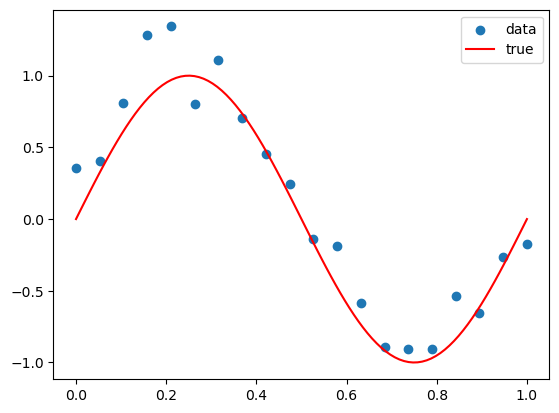

In [9]:
np.random.seed(0)
x = np.linspace(0, 1, 20)
y = np.sin( 2 * np.pi * x ) + np.random.normal(0, .2, x.shape[0])
plt.scatter(x,y, label = "data")
x_plot = np.linspace(0, 1, 100)
plt.plot(x_plot, np.sin(2*np.pi*x_plot), 'r', label = "true" )
plt.legend();
y_plot = np.sin( 2 * np.pi * x_plot ) + np.random.normal(0, .2, x_plot.shape[0])


##### e.g. spline regression (out of sample MSE)
3.(a) Fit a cubic spline regression with $k=5$ knots. Use `sklearn.preprocessing.SplineTransformer( n_knots = 5)` to create the spline bases, and use `LinearRegression()` to solve for the coefficients; you can combine these steps with `sklearn.pipeline.make_pipeline()`. 
Use the fitted model to predict the values of the function at the `x_plot` points, and calculate the MSE over the (out-of-sample) simulated `y_plot` points. Plot your model fit (on top of the data and the true regression function) and report your MSE estimate for the out-of-sample data.

Out-of-sample MSE = 0.06551063529235077


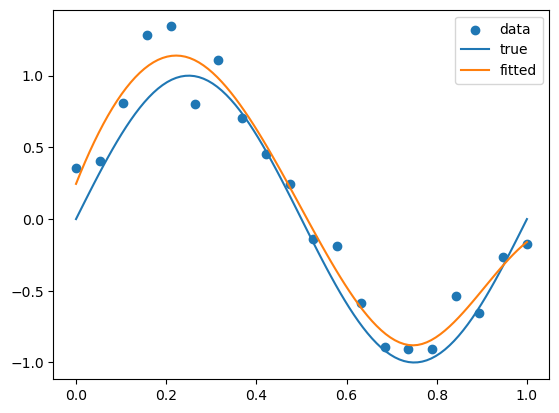

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

model = make_pipeline( SplineTransformer(n_knots=5,degree=3), LinearRegression())
model.fit(x.reshape(-1,1),y)

y_fit_a = model.predict(x_plot.reshape(-1,1))

plt.scatter(x,y, label = "data")
plt.plot(x_plot, np.sin(2*np.pi*x_plot), label = "true" )
plt.plot(x_plot, y_fit_a, label = "fitted" )
plt.legend();

out_of_sample_MSE = np.mean( (y_plot - y_pred_plot)**2 )
print( "Out-of-sample MSE =", out_of_sample_MSE )

3.(b) Repeat the previous part, but now use $k=20$ knots. The resulting fitted model should interpolate the data.

Out-of-sample MSE = 0.08860130169340265


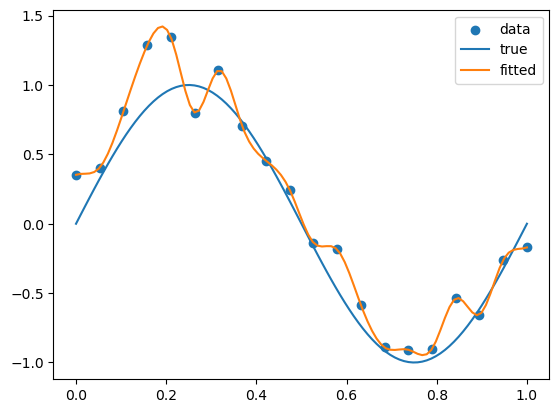

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

model = make_pipeline( SplineTransformer(n_knots=20,degree=3), LinearRegression() )
model.fit(x.reshape(-1,1),y)

y_fit_b = model.predict(x_plot.reshape(-1,1))

plt.scatter(x,y, label = "data")
plt.plot(x_plot, np.sin(2*np.pi*x_plot), label = "true" )
plt.plot(x_plot, y_fit_b, label = "fitted" )
plt.legend();

print( "Out-of-sample MSE =", np.mean( (y_plot - y_fit_b)**2 ) )

3.(c) Repeat the previous part, but now use $k=40$ knots. The model is now over-parametrized ($p>N$), but the `LinearRegression()` function in `sklearn` uses [singular value decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) which can solve undetermined linear systems of Normal equations by selecting the solution with the minimum $L^2$ norm. (i.e., the one with $\min\|w\|_2^2$). 

Out-of-sample MSE = 0.08026002255575662


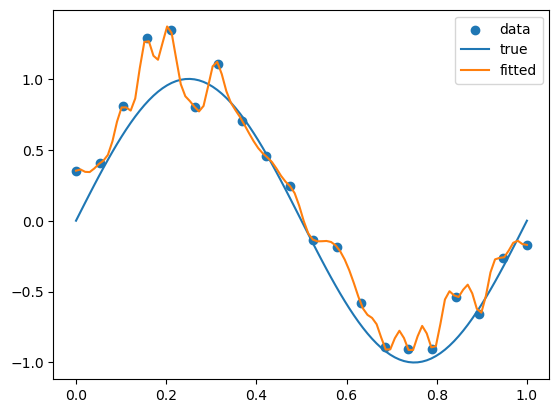

In [18]:
### K=40 

model = make_pipeline(SplineTransformer(n_knots=40,degree=3), LinearRegression())
model.fit(x.reshape(-1,1),y)

y_fit_c = model.predict(x_plot.reshape(-1,1))

plt.scatter(x,y, label = "data")
plt.plot(x_plot, np.sin(2*np.pi*x_plot), label = "true" )
plt.plot(x_plot, y_fit_c, label = "fitted" )
plt.legend();

print( "Out-of-sample MSE =", np.mean( (y_plot - y_fit_c)**2 ) )

# Note that the over-parametrized model does better (has smaller MSE) that the interpolating model, 
# demonstrating a double-descent phenomenon; 
# this behaviour is even more pronounced in *very* complex models, like deep neural nets